In [ ]:
pip install pickle5

     |████████████████████████████████| 132 kB 5.2 MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219307 sha256=1f1cd58604fc30b7f79a243d827da9230a109c8a42b8ebbe24a0e7b51eb6cecb
  Stored in directory: /root/.cache/pip/wheels/7e/6a/00/67136a90d6aca437d806d1d3cedf98106e840c97a3e5188198
Successfully built pickle5


In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")
import pickle5 as pickle
import torch
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
import copy
import scipy.interpolate as interpolate
import random
import datetime
from torch.utils.data import DataLoader, TensorDataset

RANDOM_SEED = 56
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [52]:
a = torch.rand(2, 10, 3) # 10, seq_len, 128
print(a)
print(a[:, -1, :])
print(a[:, -1, :].shape)

tensor([[[0.3829, 0.8426, 0.0821],
         [0.1265, 0.9413, 0.2288],
         [0.7923, 0.6016, 0.4555],
         [0.8206, 0.6515, 0.4981],
         [0.7851, 0.1315, 0.1132],
         [0.8205, 0.3272, 0.4745],
         [0.1631, 0.1822, 0.1407],
         [0.5953, 0.0452, 0.7859],
         [0.8993, 0.0457, 0.4232],
         [0.9887, 0.7362, 0.4266]],

        [[0.6115, 0.2519, 0.3091],
         [0.8785, 0.2119, 0.1581],
         [0.6489, 0.6345, 0.9972],
         [0.5228, 0.3024, 0.4030],
         [0.1261, 0.9702, 0.5693],
         [0.8097, 0.3753, 0.1119],
         [0.9411, 0.3942, 0.6543],
         [0.7221, 0.9654, 0.1435],
         [0.7868, 0.3158, 0.1406],
         [0.6500, 0.4415, 0.4016]]])
tensor([[0.9887, 0.7362, 0.4266],
        [0.6500, 0.4415, 0.4016]])
torch.Size([2, 3])


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google'

In [3]:
root_path = ''   #change dir to your project folder

In [4]:
# Load data
df0 = pickle.load( open( root_path + "data/aligned_GM-7792_DRD-d6b1cf27-41ed-43b6-8050-2068ef941a0aDRD-d6b1cf27-41ed-43b6-8050-2068ef941a0a_GM-7792_pass-0_cleaned.pickle", "rb" ) )
df1 = pickle.load( open( root_path + "data/aligned_GM-7792_DRD-d6b1cf27-41ed-43b6-8050-2068ef941a0aDRD-d6b1cf27-41ed-43b6-8050-2068ef941a0a_GM-7792_pass-1_cleaned.pickle", "rb" ) )

In [5]:
# Merge the two dataframes
df = df0.append(df1, ignore_index=True)
# Shuffle df
df = df.sample(frac=1.0)
df.shape

(3830, 10)

In [6]:
# Subselect data for dev
#df = df[0:1000]

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
!nvidia-smi

Mon Nov 15 00:37:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    25W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# up/downsample series

In [8]:
def resample(seq, to_length, window_size):
    '''
    Resample a sequence/
    Parameters
    ----------
    seq : np.array
        Sequence to be resampled.
    to_length : int
        Resample to this number of points.
    Returns
    -------
    d_resampled : np.array
        resampled distance (0,10)
    y_resampled : np.array
        resampled input sequence.
    '''
    # Downsample if needed
    seq_len = seq.shape[0]
    if seq_len>to_length:
        seq = choice(seq, to_length)
        seq_len = seq.shape[0] #
    # Current
    window_size = seq_len #guess if you only want to use first part of TS?
    d = np.linspace(0, window_size, seq_len)
    f = interpolate.interp1d(d, seq)
    # Generate new points
    d_new = np.random.uniform(low=0, high=d[-1], size=(to_length - seq_len))
    # Append new to the initial
    d_resampled = sorted(np.concatenate((d, d_new)))
    # Estimate y at points
    y_resampled = f(d_resampled)
    return d_resampled, y_resampled
    
def resample_df(df, feats_to_resample, to_lengths_dict = {}, window_size = None):
    input_feats_resampled = []
    # Filter rows with less than 2 points (can't resample those)
    for feat in feats_to_resample:
        df[feat+'_len'] =  df[feat].apply(lambda seq: 1 if isinstance(seq, float) else seq.shape[0])
        df.mask(df[feat+'_len']<2, inplace = True)
    # Drop nans (rows with NaN/len<2) and reset index
    df.dropna(subset = feats_to_resample, inplace = True)
    df.reset_index(drop = True, inplace = True)
    # Resample to the maximum
    for feat in feats_to_resample:
        print('Resampling feature: ',feat)
        #max_len = max(df[feat].apply(lambda seq: seq.shape[0]))
        to_length = to_lengths_dict[feat]
        new_feats_resampled = ['{0}_d_resampled'.format(feat), '{0}_resampled'.format(feat)]
        df[new_feats_resampled ] = df.apply(lambda seq: resample(seq[feat], to_length = to_length, window_size = window_size),
                                        axis=1, result_type="expand")
        input_feats_resampled.append('{0}_resampled'.format(feat))
    return df,  input_feats_resampled

In [9]:
def choice(seq, to_length):
  return np.array([seq[i] for i in sorted(random.sample(range(len(seq)), to_length))])

In [10]:
feats_to_resample = ['GM.acc.xyz.z']
to_lengths_dict = {}

for feat in feats_to_resample:
  to_lengths_dict[feat] = int(df[feat].apply(len).quantile(0.83))

In [11]:
resample_df(df, feats_to_resample, to_lengths_dict, None )

Resampling feature:  GM.acc.xyz.z


(      IRI_mean                                       IRI_sequence  \
 0     3.466545  [4.190362829, 5.7580724565, 3.8626593110000003...   
 1      1.81723  [1.2442136609999999, 2.072785271, 1.9020439945...   
 2     2.899793  [3.9273969665, 2.9459366989999998, 4.005252755...   
 3      4.02106  [2.368106586, 4.421193358, 9.9007087925, 7.132...   
 4     2.383059  [1.434841997, 1.9767201665, 1.865241845, 2.084...   
 ...        ...                                                ...   
 3825  3.770514  [6.3919734655, 2.7122621685, 2.3238099795, 3.6...   
 3826  3.146434  [2.460614889, 2.4504720825, 1.5724999955, 2.19...   
 3827  3.809389  [3.3704721745, 7.177070926999999, 7.5961139440...   
 3828  3.641557  [4.800837035000001, 2.0391156305, 1.9153844050...   
 3829  4.311855  [4.187966511, 3.8159984395, 2.9084116079999998...   
 
                                       GM.TS_or_Distance  \
 0     [2021-04-22 02:42:14.432000+00:00, 2021-04-22 ...   
 1     [2021-04-22 02:57:00.701000+00:

### Threshold data on IRI_mean > 5  <=> outlier

In [12]:
iri_threshold = 5
normal_df = df['GM.acc.xyz.z_resampled'][df['IRI_mean'] <= iri_threshold]
normal_df = pd.DataFrame(normal_df.tolist())
normal_df.shape

(3410, 3996)

In [13]:
anomaly_df = df['GM.acc.xyz.z_resampled'][df['IRI_mean'] >= iri_threshold]
anomaly_df = pd.DataFrame(anomaly_df.tolist())
anomaly_df.shape

(420, 3996)

In [14]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

# convert to tensors

In [15]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [16]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

## DataLoader

In [17]:
batch_size = 100 #crashes at larger than 100 with 1 hidden layer

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [18]:
x = next(iter(train_dataloader))
x.shape

torch.Size([100, 3996, 1])

# Define Model

In [19]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(          #(Batch Size, Sequence Length, Hidden Units)
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )

    def forward(self, x, batch_size):
        #x = x.reshape((batch_size, self.seq_len, self.n_features))
        #print('førstelag1', x.shape)
        x, (_, _) = self.rnn1(x)
        #print('førstelag2', x.shape)
        x, (hidden_n, _) = self.rnn2(x)
        
        #print('b', x.shape)
        #print('c',hidden_n.shape)
        
        return hidden_n.reshape((batch_size, self.n_features, self.embedding_dim))

In [20]:
class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(    
          input_size=self.input_dim,
          hidden_size=self.input_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=self.input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x, batch_size):
        #print('0', x.shape)
        x = x.repeat(1, self.seq_len, self.n_features)
        #print('1', x.shape)
        x = x.reshape((batch_size, self.seq_len, self.input_dim))
        #print('2', x.shape)
        
        x, (hidden_n, cell_n) = self.rnn1(x)
        #print('3', x.shape)
        x, (hidden_n, cell_n) = self.rnn2(x)
        #print('4', x.shape)
        
        x = x.reshape((batch_size, self.seq_len, self.hidden_dim))
        #print('5', x.shape)
        return self.output_layer(x)

In [21]:
class RecurrentAutoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x, batch_size):
        
        x = self.encoder(x, batch_size)
        x = self.decoder(x, batch_size)

        return x

# Training loop

In [25]:
def train_model(model, train_dataloader, val_dataloader, n_epochs, batch_size):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())   # Save model
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        #for seq_true in train_dataset:
        for i, X in enumerate(train_dataloader):
            seq_true = X.to(device)
            seq_pred = model(seq_true, batch_size)

            loss = criterion(seq_pred, seq_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            print('Batch iteration:', i)
     
        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for X in val_dataloader:
                seq_true = X.to(device)
                seq_pred = model(seq_true, batch_size)
            
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        #print(train_losses)    
        train_loss = np.mean(train_losses)

        #print(val_losses)    
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict()) # save model

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

# Clear cuda cache

In [26]:
# Clear memory
try:
  del model
except:
  print("No model initiated")

torch.cuda.empty_cache()
#print(torch.cuda.memory_summary(device=None, abbreviated=False))

# Instantiate model

In [27]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

# Train model

In [28]:
print(datetime.datetime.now())

model, history = train_model(
  model, 
  train_dataloader, 
  val_dataloader, 
  n_epochs=1,
  batch_size = batch_size
)

print(datetime.datetime.now())

2021-11-15 10:25:01.048099
Batch iteration: 0
Batch iteration: 1


KeyboardInterrupt: 

# Loss plot

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

#Save model

In [ ]:
MODEL_PATH = 'model.pth'

torch.save(model.state_dict(), root_path+MODEL_PATH)

# Load model

In [ ]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)
model.load_state_dict(torch.load(root_path + 'model.pth'))
model.eval()

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

# Prediction plots

In [ ]:
def predict(model, dataset, batch_size):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = torch.unsqueeze(seq_true,0)
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true, batch_size)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [ ]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data], batch_size=1)

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

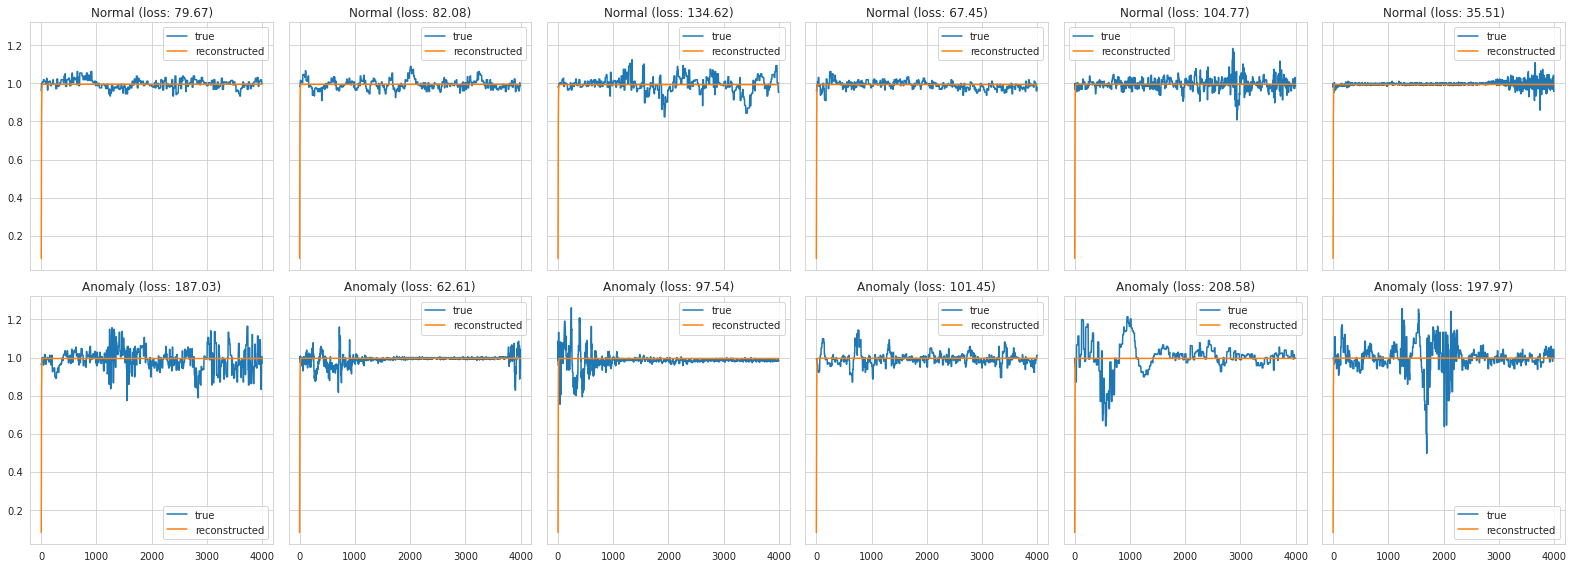

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)


for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();